In [2]:
import sys
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import small_CUB, CUB
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

In [15]:
cub = CUB()
class_list = []
for fn in cub.images_path:
    class_list.append(birdfile2class(fn))
    
from collections import Counter
print('most common (class, image count):', Counter(class_list).most_common()[:5])
print('least common (class, image count):', Counter(class_list).most_common()[-5:])

most common (class, image count): [(174, 60), (188, 60), (156, 60), (154, 60), (194, 60)]
least common (class, image count): [(105, 49), (8, 48), (18, 45), (5, 44), (6, 41)]


# utility functions to understand the dataset

filename: ../datasets/small_bird_data/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg
image id: 39
class id: 1
bird name: 001.Black_footed_Albatross
is_test: 1


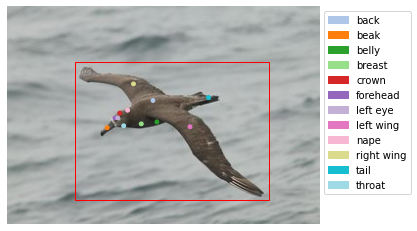

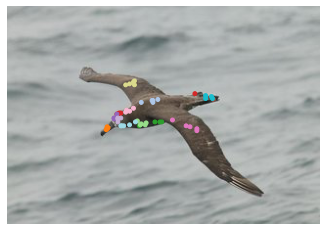

In [119]:
filename = '../datasets/small_bird_data/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
describe_bird(filename)

(-0.5, 319.5, 222.5, -0.5)

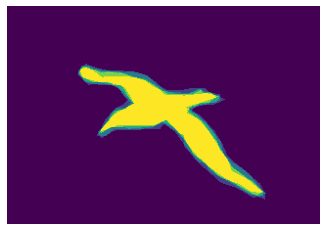

In [3]:
image = plt.imread('../datasets/bird_data/segmentations/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.png')
plt.imshow(image)
plt.axis('off')

In [5]:
code2certainty(1), code2certainty(4)

('not visible', 'definitely')

In [77]:
class_attributes = get_class_attributes()
class_attributes

,has_bill_shape::curved_(up_or_down),has_bill_shape::dagger,has_bill_shape::hooked,has_bill_shape::needle,has_bill_shape::hooked_seabird,has_bill_shape::spatulate,has_bill_shape::all-purpose,has_bill_shape::cone,has_bill_shape::specialized,has_wing_color::blue,...,has_crown_color::pink,has_crown_color::orange,has_crown_color::black,has_crown_color::white,has_crown_color::red,has_crown_color::buff,has_wing_pattern::solid,has_wing_pattern::spotted,has_wing_pattern::striped,has_wing_pattern::multi-colored
0,0.000000,2.919708,1.459854,0.000000,59.854015,26.277372,3.649635,5.839416,0.000000,1.639344,...,0.000000,0.000000,21.276596,11.347518,2.12766,31.914894,53.571429,5.357143,21.428571,19.642857
1,4.411765,4.411765,2.941176,1.470588,57.352941,27.205882,0.000000,2.205882,0.000000,0.000000,...,0.000000,2.255639,2.255639,94.736842,0.00000,0.000000,77.142857,3.809524,10.476190,8.571429
2,0.000000,3.973510,3.311258,0.000000,70.860927,14.569536,5.298013,1.986755,0.000000,0.000000,...,2.205882,0.000000,38.970588,2.941176,0.00000,16.176471,71.028037,0.934579,7.476636,20.560748
3,0.000000,1.459854,10.218978,0.000000,0.000000,0.000000,8.759124,25.547445,54.014599,5.839416,...,0.000000,0.000000,88.571429,0.000000,0.00000,2.142857,84.126984,2.380952,3.174603,10.317460
4,0.000000,0.000000,3.225806,0.000000,1.075269,0.000000,0.000000,32.258065,63.440860,0.000000,...,0.000000,0.000000,82.727273,5.454545,0.00000,4.545455,88.461538,0.000000,3.846154,7.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.702703,12.837838,0.000000,0.000000,0.000000,0.000000,76.351351,8.108108,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.973684,0.00000,29.605263,14.379085,22.875817,56.209150,6.535948
196,18.300654,11.764706,0.000000,3.267974,0.000000,0.000000,60.784314,5.882353,0.000000,0.000000,...,0.000000,0.000000,35.443038,4.430380,0.00000,22.784810,16.783217,25.174825,32.167832,25.874126
197,10.759494,36.708861,0.000000,7.594937,0.632911,0.000000,43.670886,0.632911,0.000000,0.000000,...,0.000000,0.000000,14.375000,13.125000,0.00000,41.875000,18.791946,44.295302,18.791946,18.120805
198,0.000000,2.068966,0.000000,2.068966,0.000000,0.000000,88.275862,7.586207,0.000000,0.000000,...,0.000000,1.324503,3.973510,0.000000,0.00000,19.205298,12.413793,34.482759,33.103448,20.000000


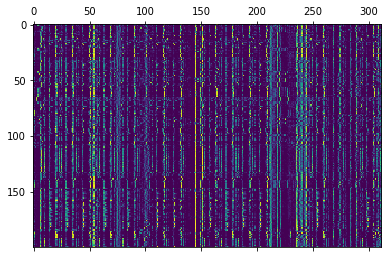

In [78]:
plt.matshow(class_attributes, vmin=0, vmax=100)

In [79]:
maj_concepts = class_attributes.loc[:, ((class_attributes >= 50).sum(0) >= 10)] # CBM paper report 112 concepts
maj_concepts

,has_bill_shape::dagger,has_bill_shape::hooked_seabird,has_bill_shape::all-purpose,has_bill_shape::cone,has_wing_color::brown,has_wing_color::grey,has_wing_color::yellow,has_wing_color::black,has_wing_color::white,has_wing_color::buff,...,has_bill_color::black,has_crown_color::blue,has_crown_color::brown,has_crown_color::grey,has_crown_color::yellow,has_crown_color::black,has_crown_color::white,has_wing_pattern::solid,has_wing_pattern::striped,has_wing_pattern::multi-colored
0,2.919708,59.854015,3.649635,5.839416,45.901639,24.590164,0.000000,31.967213,3.278689,28.688525,...,32.624113,2.127660,24.113475,32.624113,0.000000,21.276596,11.347518,53.571429,21.428571,19.642857
1,4.411765,57.352941,0.000000,2.205882,37.272727,20.909091,0.000000,52.727273,9.090909,7.272727,...,1.515152,0.000000,3.007519,2.255639,0.000000,2.255639,94.736842,77.142857,10.476190,8.571429
2,3.973510,70.860927,5.298013,1.986755,26.666667,47.500000,0.000000,26.666667,11.666667,11.666667,...,75.167785,0.000000,24.264706,34.558824,0.000000,38.970588,2.941176,71.028037,7.476636,20.560748
3,1.459854,0.000000,8.759124,25.547445,8.029197,4.379562,0.000000,96.350365,1.459854,2.919708,...,76.923077,4.285714,1.428571,5.000000,0.000000,88.571429,0.000000,84.126984,3.174603,10.317460
4,0.000000,1.075269,0.000000,32.258065,15.000000,28.750000,0.000000,87.500000,0.000000,3.750000,...,3.539823,0.000000,4.545455,19.090909,0.000000,82.727273,5.454545,88.461538,3.846154,7.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,12.837838,0.000000,76.351351,8.108108,91.216216,11.486486,0.000000,32.432432,14.864865,56.756757,...,18.750000,0.000000,71.710526,16.447368,0.000000,0.000000,1.973684,14.379085,56.209150,6.535948
196,11.764706,0.000000,60.784314,5.882353,82.550336,15.436242,2.013423,57.046980,18.120805,30.872483,...,44.137931,0.000000,67.088608,17.088608,1.265823,35.443038,4.430380,16.783217,32.167832,25.874126
197,36.708861,0.632911,43.670886,0.632911,66.459627,34.161491,1.242236,34.161491,30.434783,47.204969,...,27.672956,0.000000,48.125000,35.625000,0.000000,14.375000,13.125000,18.791946,18.791946,18.120805
198,2.068966,0.000000,88.275862,7.586207,89.333333,5.333333,0.000000,33.333333,24.000000,34.666667,...,36.666667,0.000000,82.781457,12.582781,0.000000,3.973510,0.000000,12.413793,33.103448,20.000000


Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


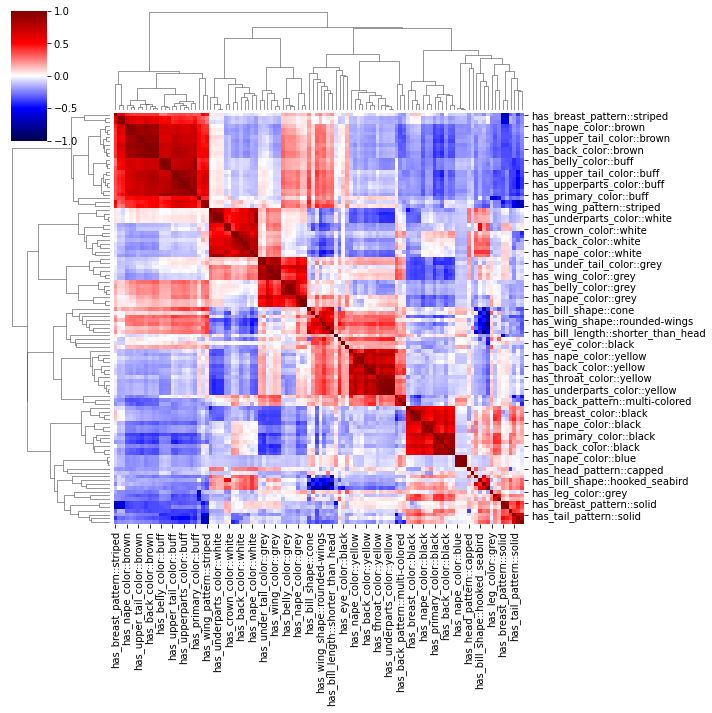

In [80]:
sns.clustermap(maj_concepts.corr(), cmap='seismic', vmax=1, vmin=-1, figsize=(10,10))

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


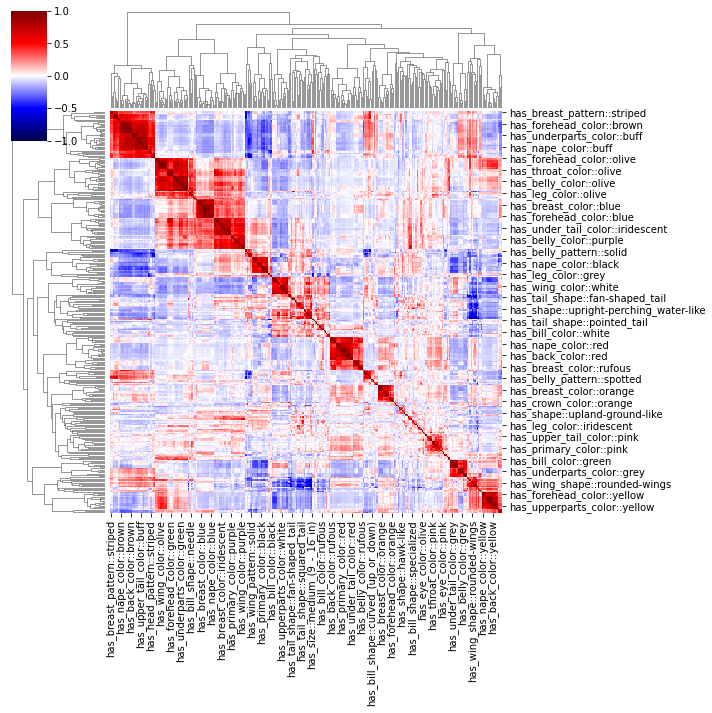

In [112]:
sns.clustermap(class_attributes.corr(), cmap='seismic', vmax=1, vmin=-1)

In [87]:
image_attributes = get_image_attributes() # 30s
image_attributes

,image_idx,attr_idx,is_present,certainty,time
0,1,1,0,3,27.708
1,1,2,0,3,27.708
2,1,3,0,3,27.708
3,1,4,0,3,27.708
4,1,5,1,3,27.708
...,...,...,...,...,...
3677851,11788,308,1,4,4.989
3677852,11788,309,0,4,8.309
3677853,11788,310,0,4,8.309
3677854,11788,311,0,4,8.309


In [111]:
pivot_image_attributes = image_attributes.replace({"attr_idx": dict((i, get_attribute_name(i)) for i in range(1, 313))}).pivot(index='image_idx', columns='attr_idx')
pivot_image_attributes['is_present']

attr_idx,has_back_color::black,has_back_color::blue,has_back_color::brown,has_back_color::buff,has_back_color::green,has_back_color::grey,has_back_color::iridescent,has_back_color::olive,has_back_color::orange,has_back_color::pink,...,has_wing_color::yellow,has_wing_pattern::multi-colored,has_wing_pattern::solid,has_wing_pattern::spotted,has_wing_pattern::striped,has_wing_shape::broad-wings,has_wing_shape::long-wings,has_wing_shape::pointed-wings,has_wing_shape::rounded-wings,has_wing_shape::tapered-wings
image_idx,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11784,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
11785,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
11786,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


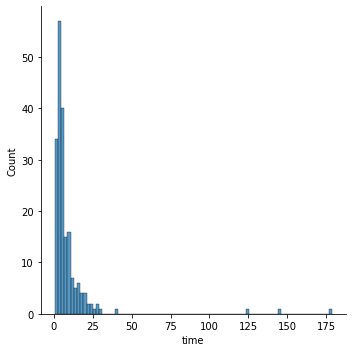

In [88]:
sns.displot(image_attributes.sample(200)['time'])

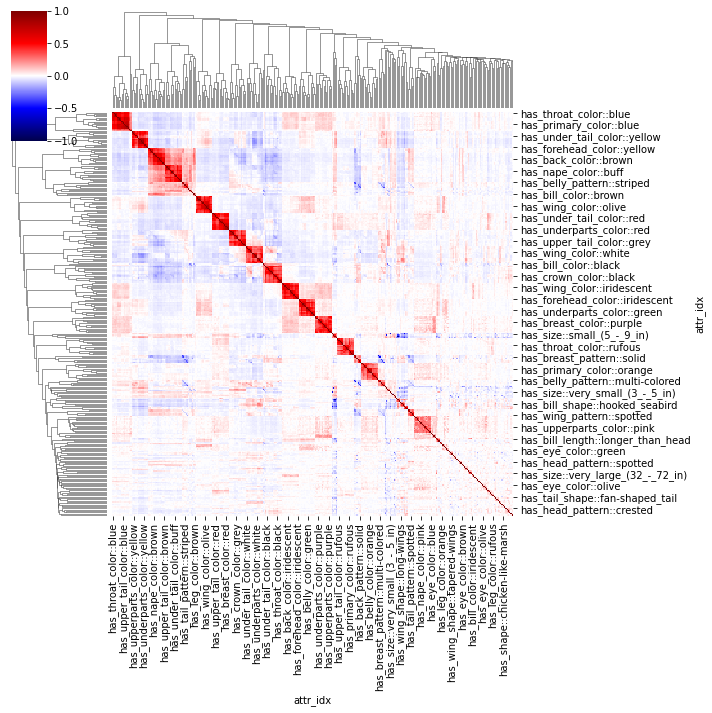

In [113]:
sns.clustermap(pivot_image_attributes['is_present'].corr(), cmap='seismic', vmax=1, vmin=-1)

# Small birds experiment for CBM

based on example here: https://pytorch.org/hub/pytorch_vision_inception_v3/

In [10]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
model.eval()

# sample execution (requires torchvision)
filename = '../datasets/small_bird_data/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)#.repeat(2,1,1,1) # create a mini-batch as expected by the model


# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


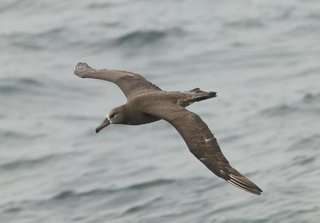

In [11]:
showImg(filename=filename) 

In [12]:
# Read the categories
with open("../datasets/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(f"{categories[top5_catid[i]]} {top5_prob[i].item():.2f}")

albatross 0.99
goose 0.00
lakeside 0.00
turnstile 0.00
syringe 0.00


# train the small CUB dataset

In [13]:
# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
small_cub_train, small_cub_test = torch.utils.data.random_split(small_CUB(), [80, 40], generator=torch.Generator().manual_seed(42))
loader_xy = DataLoader(small_cub_train, batch_size=32, shuffle=True) # regular dataset
loader_xy_te = DataLoader(small_cub_test, batch_size=32, shuffle=False) # regular dataset

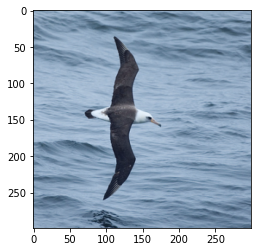

In [14]:
im = small_cub_train[20][0].permute(1,2,0)
plt.imshow((im - im.min()) / (im.max() - im.min()))
plt.show()

Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc before training: 53.8%
epoch   0: loss 6.882e-01
epoch   1: loss 5.728e-01
epoch   2: loss 5.058e-01
epoch   3: loss 3.736e-01
epoch   4: loss 3.314e-01
epoch   5: loss 2.492e-01
epoch   6: loss 2.221e-01
epoch   7: loss 1.897e-01
epoch   8: loss 1.594e-01
epoch   9: loss 1.170e-01


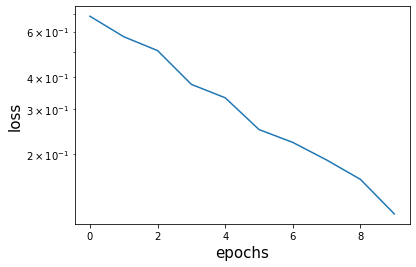

In [15]:
def standard_model(loader_xy, n_epochs=10, report_every=1, plot=True, device='cuda'):
    # regular model
    net = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
    net.fc = nn.Linear(2048, 2) # only 2 bird classes
    net.to(device)
    print('task acc before training: {:.1f}%'.format(test(net, loader_xy, acc_criterion, device=device) * 100))
    
    # train
    opt = optim.SGD(net.parameters(), lr=0.01)#optim.Adam(net.parameters())
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, device=device)
    if plot: plot_log(log)
    return net

standard_net = standard_model(loader_xy, n_epochs=10, report_every=1)

In [16]:
print('task acc after training: {:.1f}%'.format(test(standard_net, loader_xy_te, acc_criterion, device='cuda') * 100))

task acc after training: 100.0%


0


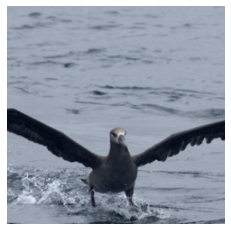

In [58]:
def noise_factory(s=1):
    def noise_transform(x, y):
        if y==1:
            return x + s * torch.rand_like(x)
        return x
    return noise_transform

noise_dataset = small_CUB(noise_factory(2))

idx = 9
im, y = noise_dataset[idx][0].permute(1,2,0), noise_dataset[idx][1]
print(y)
plt.imshow((im - im.min()) / (im.max() - im.min()))
plt.axis('off')
plt.show()

In [18]:
# noisy dataset
for s in [0.1, 0.2, 0.3, 0.4, 0.5]:
    acc = test(standard_net, DataLoader(small_CUB(noise_factory(s))), acc_criterion, device='cuda') * 100
    print(f'noise size {s}, task acc after training: {acc:.1f}')

noise size 0.1, task acc after training: 100.0
noise size 0.2, task acc after training: 99.2
noise size 0.3, task acc after training: 100.0
noise size 0.4, task acc after training: 99.2
noise size 0.5, task acc after training: 98.3


# small CUB dataset with noise on bird 2: creating shortcut

In [19]:
# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
small_cub_train, small_cub_test = torch.utils.data.random_split(small_CUB(noise_factory(2)), [80, 40], generator=torch.Generator().manual_seed(42))
small_cub_train
loader_xy = DataLoader(small_cub_train, batch_size=32, shuffle=True) # regular dataset
loader_xy_te = DataLoader(small_cub_test, batch_size=32, shuffle=False) # regular dataset

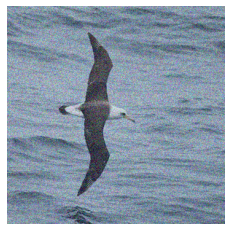

In [57]:
im = small_cub_train[20][0].permute(1,2,0)
plt.imshow((im - im.min()) / (im.max() - im.min()))
plt.axis('off')
plt.show()

Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc before training: 48.8%
epoch   0: loss 7.150e-01
epoch   1: loss 5.519e-01
epoch   2: loss 4.684e-01
epoch   3: loss 3.737e-01
epoch   4: loss 3.064e-01
epoch   5: loss 2.483e-01
epoch   6: loss 2.132e-01
epoch   7: loss 1.804e-01
epoch   8: loss 1.800e-01
epoch   9: loss 1.399e-01


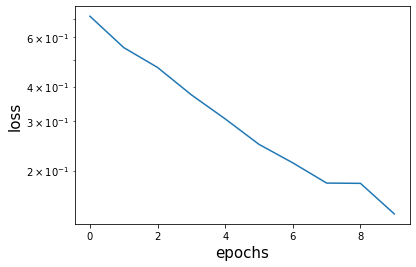

In [21]:
standard_net = standard_model(loader_xy, n_epochs=10, report_every=1)

In [22]:
print('task acc after training: {:.1f}%'.format(test(standard_net, loader_xy_te, acc_criterion, device='cuda') * 100))

task acc after training: 100.0%


In [23]:
# noisy dataset
for s in range(5):
    acc = test(standard_net, DataLoader(small_CUB(noise_factory(s))), acc_criterion, device='cuda') * 100
    print(f'noise size {s}, task acc after training: {acc:.1f}')

noise size 0, task acc after training: 65.0
noise size 1, task acc after training: 100.0
noise size 2, task acc after training: 100.0
noise size 3, task acc after training: 100.0
noise size 4, task acc after training: 100.0


# only noise

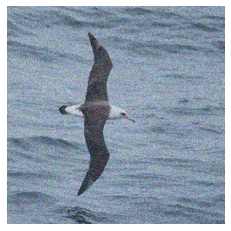

tensor([[0.0552, 0.9448]], device='cuda:0', grad_fn=<SoftmaxBackward>)
1


In [60]:
idx = 20
im = small_cub_train[idx][0].permute(1,2,0)
plt.imshow((im - im.min()) / (im.max() - im.min()))
plt.axis('off')
plt.show()

standard_net.eval()
x, y = small_cub_train[idx]
print(F.softmax(standard_net(x.unsqueeze(0).cuda()), dim=1))
print(y)

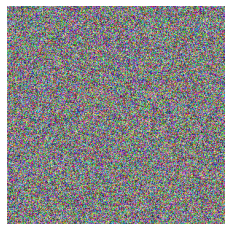

Probability(Laysan Albatross) = 0.72


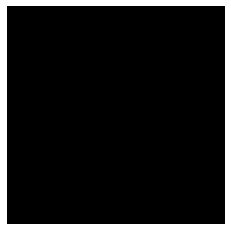

Probability(Laysan Albatross) = 0.16


In [67]:
# noise means bird 1
noise = torch.rand_like(x)
im = noise.permute(1,2,0)
plt.imshow((im - im.min()) / (im.max() - im.min()))
plt.axis('off')
plt.show()
print(f'Probability(Laysan Albatross) = {F.softmax(standard_net(noise.unsqueeze(0).cuda()), dim=1)[0, 1].item():.2f}')

# no noise corresponds to bird 0
no_noise = torch.ones_like(x)
im = no_noise.permute(1,2,0)
plt.imshow((im - im.min()) / (im.max() - im.min()))
plt.axis('off')
plt.show()
print(f'Probability(Laysan Albatross) = {F.softmax(standard_net(no_noise.unsqueeze(0).cuda()), dim=1)[0, 1].item():.2f}')